# A simple GPY example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

Want to model a noisey sin wave as a 1-dimensional Gaussian Process.
First we create the data:
* $\bf x$ taken from a uniform random distribution, then random Gaussian noise $\epsilon$ added: $\bf y = f(\bf x) + {\bf \epsilon}$
* Test points uniformly taken from along the domain

In [2]:
np.random.seed(1234)
train_size = 50
test_size = 10

x = np.arange(0, 25, 0.1)
f = lambda x: np.sin(x)
y = f(x)

train_x = np.random.uniform(0, 25, size = (train_size, 1))
train_x.sort()
train_y = f(train_x) + np.random.normal(scale = 0.15, size = (train_size, 1))

train = {'x': train_x, 'y': train_y}

test_x = np.arange(0, 25, 25/test_size).reshape(-1, 1)
test_x.sort()
test_y = f(test_x)

test = {'x': test_x, 'y': test_y}

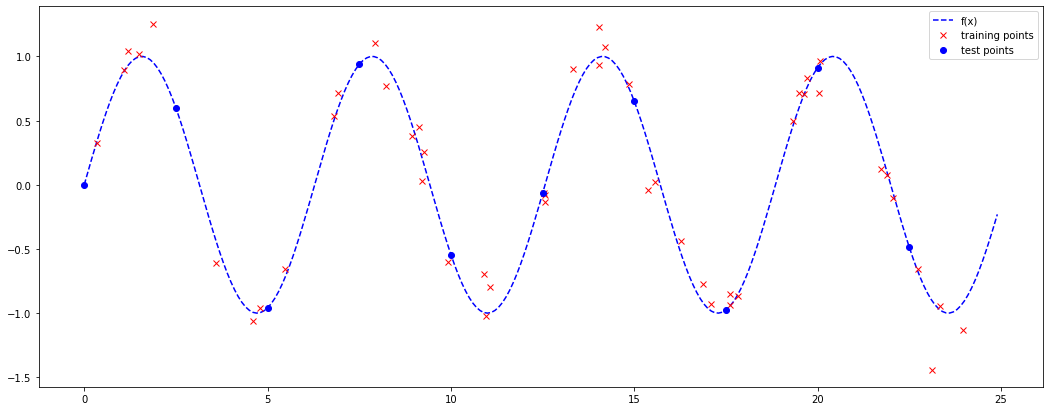

In [3]:
plt.figure(figsize = (18, 7))
plt.plot(x, y, 'b--', label = 'f(x)')
plt.plot(train_x, train_y, 'rx', label = 'training points')
plt.plot(test_x, test_y, 'bo', label = 'test points')
plt.legend()
plt.show()


Name : GP regression
Objective : 64.60344903531764
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  sum.rbf.variance         |    1.0  |      +ve      |        
  sum.rbf.lengthscale      |    1.0  |      +ve      |        
  sum.Mat32.variance       |    1.0  |      +ve      |        
  sum.Mat32.lengthscale    |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


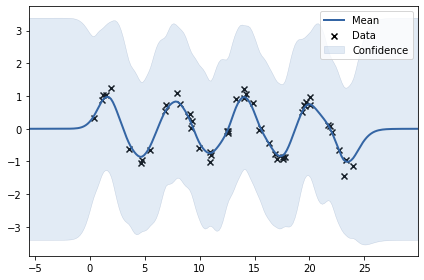

In [37]:
kern = GPy.kern.RBF(1) + GPy.kern.Matern32(1)
model = GPy.models.GPRegression(train_x.reshape(-1, 1), train_y.reshape(-1, 1), kern)
print(model)
model.plot();

Optimization restart 1/5, f = 7.4556306123532075
Optimization restart 2/5, f = 7.455633072613018
Optimization restart 3/5, f = 7.455630531688609
Optimization restart 4/5, f = 7.455630368800701
Optimization restart 5/5, f = 7.455630264588045

Name : GP regression
Objective : 7.455630264588045
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  sum.rbf.variance         |      0.6821212695407559  |      +ve      |        
  sum.rbf.lengthscale      |      1.4319159126427672  |      +ve      |        
  sum.Mat32.variance       |  1.2110034785081285e-08  |      +ve      |        
  sum.Mat32.lengthscale    |        9.27974458473675  |      +ve      |        
  Gaussian_noise.variance  |    0.019956797646095457  |      +ve      |        


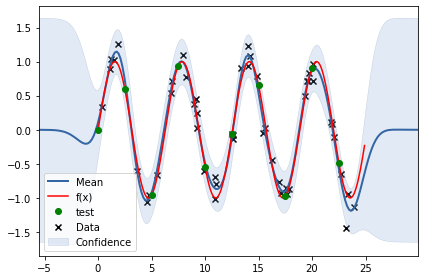

In [38]:
model.optimize_restarts(5)
print(model)
model.plot()
plt.plot(x, y, 'r', label = 'f(x)')
plt.plot(test_x, test_y, 'go', label = 'test')
plt.legend()
plt.show()

Now we define a function to get the average uncertainty over the test points, taking into account the uncertainty in the hyperparameters. This just uses the GP uncertainty at the test sites. **The hyperparameters are sampled with a Hybrid Monte Carlo algorithm. Is this the best way to do it?**

Also, the average uncertainty is a weighted average of the uncertainties for each set of hyperparameters, weighted by the log-likelihood of the model. **Should it be weighted by the likelihood, the log-likelihood or something else? There is a log_likelihood() function for the GP model which is what I'm using, is this the right thing to use?**

In [6]:
def gauss_pdf(x, mu, var):
    return (1/np.sqrt(2*np.pi*var)) * np.exp(-0.5 * ((x - mu)**2)/var)

In [9]:
def get_average_uncertainty(model, train_points, test_points, hp_samples, hp_weights, is_test_known = False):
    """ Gets the sum of the nlpds of test points across hyperparameters.
    
    args:
        model: the gp regression model being used
        train_points: the set of train points to fit the GP to, in the form {'x': np.array, 'y': np.array}
        test_points: the set of points which the NLPD will be assessed on, of the form {'x': np.array, 'y': np.array}
        hp_samples: a dict of hyperparameter samples
        
    returns:
        total_uncertainty: the sum of the NLPDs, divided by the number of hyperparameter samples
        uncertainty: the NLPD at each point for each sample, in an (n samples, n test points) array.
    """
    n_param_samples = len(hp_samples.items()[0][1])
    m = model.copy()
    uncertainty = np.empty(shape = (n_param_samples, len(test_points['x'])))
    for i in range(n_param_samples):
        hyperparams = {param: values[i] for param, values in hp_samples.items()}
        for param, value in hyperparams:
            hp_index = np.where(m.parameter_names == param)[0]
            m.param_array[hp_index] = value
        mean, var = m.predict(test_points['x'])
        if is_test_known:
            error = -np.log(gauss_pdf(test_points['y'], mean, var)) # NLPD
        else:
            error = np.sqrt(var) # Predicted SD
        uncertainty[i, :] = error.reshape(1, -1)
    total_uncertainty = np.sum(uncertainty)/len(hp_samples.item)
    return total_uncertainty, uncertainty

Now we define a kernel to feed into the function. We could set a prior distribution on the hyperparameters to encode our prior beliefs about them.

In [85]:
param_dict = {
    'rbf.variance': 5,
    'rbf.lengthscale': 2
}
print(model.param_array)
print(model.parameter_names)

[1.00000000e+01 1.43191591e+00 1.21100348e-08 9.27974458e+00
 1.99567976e-02]
<bound method OptimizationHandlable.parameter_names of <GPy.models.gp_regression.GPRegression object at 0x7f56984e5b50>>


In [95]:
m1 = model.copy()
m1.set_XY(train['x'], train['y'])
np.array(m1.Y)

array([[-0.95997506],
       [ 0.02004764],
       [-1.01914766],
       [ 0.70915014],
       [ 0.71837055],
       [ 0.53922918],
       [ 0.71401953],
       [ 0.71416703],
       [-1.13461887],
       [ 0.0775617 ],
       [ 0.3789628 ],
       [-0.0631735 ],
       [-0.92848595],
       [-0.86365656],
       [ 0.25257349],
       [ 1.22610173],
       [-0.13542714],
       [ 0.32690256],
       [ 0.50007064],
       [-0.10608605],
       [ 0.45310026],
       [-0.04259943],
       [ 1.25577817],
       [ 0.03136742],
       [-0.94109334],
       [-0.43937675],
       [-0.60187342],
       [ 0.83279746],
       [ 1.10339583],
       [ 1.07639495],
       [ 0.12100549],
       [-0.69466419],
       [ 0.96757389],
       [-0.61018427],
       [-0.8519674 ],
       [-0.93822895],
       [-0.65695652],
       [-1.43917087],
       [-0.80015584],
       [-0.65268491],
       [ 1.0218257 ],
       [-1.05898469],
       [ 1.04118309],
       [-0.77067902],
       [ 0.78683083],
       [ 0

In [9]:
kern = GPy.kern.RBF(1)
# Can define a prior on any of the hyperparameters we would like:
# kern.variance.set_prior(GPy.priors.Gamma(1, 1/model[0]), False)
# kern.lengthscale.set_prior(GPy.priors.Gamma(1, 1/model[1]), False)
average_uncertainty, uncertainty_mat = get_average_uncertainty(kern, train, test, 1000, True)

In [10]:
uncertainty_x = np.mean(uncertainty_mat, axis = 0) # Average uncertainty at each test location
plt.plot(test['x'], uncertainty_x);

NameError: name 'uncertainty_mat' is not defined

In [12]:
num_samples = 2000
hmc = GPy.inference.mcmc.HMC(model, stepsize = 0.05)
hyp_samples = hmc.sample(num_samples, 5)
log_likelihoods = []
for i in range(hyp_samples.shape[0]):
    model[:] = hyp_samples[i, :]
    log_likelihoods.append(model.log_likelihood())

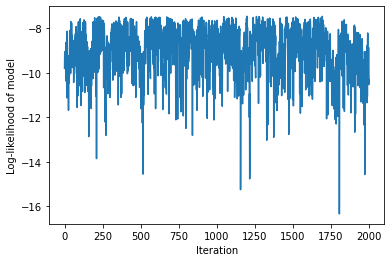

In [13]:
plt.plot(range(len(log_likelihoods)), log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood of model')
plt.show()

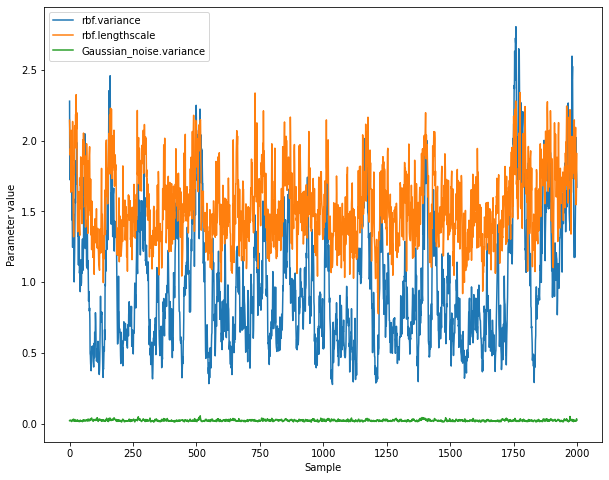

In [14]:
plt.figure(figsize = (10, 8))
plt.plot(range(num_samples), hyp_samples[:, 0], label = 'rbf.variance')
plt.plot(range(num_samples), hyp_samples[:, 1], label = 'rbf.lengthscale')
plt.plot(range(num_samples), hyp_samples[:, 2], label = 'Gaussian_noise.variance')
plt.xlabel('Sample')
plt.ylabel('Parameter value')
plt.legend();

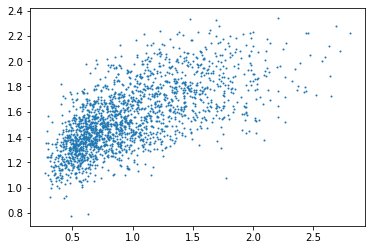

In [26]:
plt.scatter(hyp_samples[:, 0], hyp_samples[:, 1], 1)

Text(0.5, 0, 'rbf.variance')

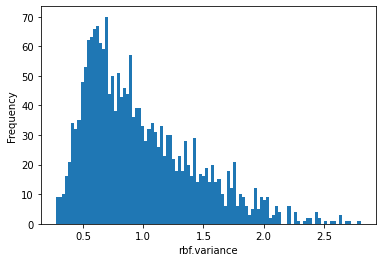

In [15]:
plt.hist(hyp_samples[:, 0], 100);
plt.ylabel('Frequency')
plt.xlabel('rbf.variance')

In [16]:
def gelman_rubin(chains):
    """ Calculate the Gelman-Rubin statistic for the chains.
    
    Args:
        chains (array): (M, N) array where the mth row is the mth chain of samples from the posterior.
    
    Returns:
        GR statistic
    """
    M, N = chains.shape
    theta_hat_m = np.mean(chains, axis = 1)
    sigma_sq_m = np.var(chains, axis = 1)
    theta_hat = np.mean(chains)
    
    B = (N/(M-1))*np.sum((theta_hat_m-theta_hat)**2)
    W = (1/M) * np.sum(sigma_sq_m)
    
    V_hat = ((N-1)/N) * W + ((M+1)/(M*N)) * B
    
    return V_hat/W

In [22]:
samples = 2000
n_chains = 3
chains = np.empty(shape = (n_chains, samples))
for i in range(n_chains):
    chains[i] = hmc.sample(5*samples + 1000, 5)[1000::5, 0]

In [23]:
gelman_rubin(chains)

1.0365416507448832